In [1]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

# Water Rocket

Author: Bernardo Bahia Monteiro (bbahia@umich.edu)

In this example, we will optimize a water rocket for range and height at the apogee, using design variables that are easily modifiable just before launch: the empty mass, the initial water volume and the launch angle.
This example builds on [multi-phase cannonball](../multi_phase_cannonball/multi_phase_cannonball.md) ane is adapted from _Optimization of a Water Rocket in OpenMDAO/Dymos_ {cite}`bbahia_2020`.

## Nomenclature

| Symbol               | definition                             |
|----------------------|----------------------------------------|
| $v_\text{out}$       | water exit speed at the nozzle         |
| $A_\text{out}$       | nozzle area                            |
| $V_w$                | water volume in the rocket             |
| $p$                  | pressure in the rocket                 |
| $p_a$                | ambient pressure                       |
| $\dot{\,}$           | time derivative                        |
| $k$                  | polytropic constant                    |
| $V_b$                | internal volume of the rocket          |
| $\rho_w$             | water density                          |
| $T$                  | thrust                                 |
| $q$                  | dynamic pressure                       |
| $S$                  | cross sectional area                   |
| $(\cdot)_0$          | value of $(\cdot)$ at $t=0$            |
| $t$                  | time                                   |

## Problem Formulation

A natural objective function for a water rocket is the maximum height achieved by the rocket during flight, or the horizontal distance it travels, i.e. its range.
The design of a water rocket is somewhat constrained by the soda bottle used as its engine.
This means that the volume available for water and air is fixed, the initial launch pressure is limited by the bottle's strength (since the pressure is directly related to the energy available for the rocket, it is easy to see that it should be as high as possible) and the nozzle throat area is also fixed.
Given these manufacturing constraints, the design variables we are left with are the empty mass (it can be easily changed through adding ballast), the water volume at the launch, and the launch angle.
With this considerations in mind, a natural formulation for the water rocket problem is

\begin{align}
    \text{maximize}   &\quad \text{range or height} \\
    \text{w.r.t.}     &\quad \text{empty mass, initial water volume, launch angle, trajectory} \\
    \text{subject to} &\quad \text{flight dynamics} \\
                      &\quad \text{fluid dynamics inside the rocket} \\
                      &\quad 0 < \text{initial water volume} < \text{volume of bottle} \\
                      &\quad 0^\circ < \text{launch angle} < 90^\circ \\
                      &\quad 0 < \text{empty mass}
\end{align}

##  Model

The water rocket model is divided into three basic components: a *water engine*, responsible for modelling the fluid dynamics inside the rocket and returning its thrust;  the *aerodynamics*, responsible for calculating the atmospheric drag of the rocket; and the *equations of motion*, responsible for propagating the rocket's trajectory in time, using Newton's laws and the forces provided by the other two components.

In order to integrate these three basic components, some additional interfacing components are necessary: an atmospheric model to provide values of ambient pressure for the water engine and air density to the calculation of the dynamic pressure for the aerodynamic model, and a component that calculates the instantaneous mass of the rocket by summing the water mass with the rocket's empty mass.
The high level layout of this model is shown in below.

<figure>
  <img src="figures/water_rocket_overview.svg"/>
  <figcaption>N2 diagram for the water rocket model</figcaption>
</figure>

`atmos`, `dynamic_pressure`, `aero` and `eom` are the same models used in [multi-phase cannonball](../multi_phase_cannonball/multi_phase_cannonball.md).
The remaining components are discussed below.

```{Warning}
The `eom` component has a singularity in the flight path angle derivative when the flight speed is zero.
This happens because the rotational dynamics are not modelled.
This can cause convergence problems if the launch velocity is set to zero or the launch angle is set to $90^\circ$
```

```{Note}
Since the range of altitudes achieved by the water rocket is very small (100m), the air density and pressure are practically constant, thus the use of an atmospheric model is not necessary. However, using it makes it easier to reuse code from [multi-phase cannonball (../multi_phase_cannonball/multi_phase_cannonball.md).
```

### Water engine

The water engine is modelled by assuming that the air expansion in the rocket
follows an adiabatic process and the water flow is incompressible and inviscid,
i.e.  it follows Bernoulli's equation. We also make the following simplifying
assumptions:

1. The thrust developed after the water is depleted is negligible
2. The area inside the bottle is much smaller than the nozzle area
3. The inertial forces do not affect the fluid dynamics inside the bottle

This simplified modelling can be found in Prusa[@Prusa2000].
A more rigorous formulation, which drops all these simplifying assumptions can be found in Wheeler[@Wheeler2002], Gommes[@Gommes2010], and Barria-Perotti[@BarrioPerotti2010].

The first assumption leads to an underestimation of the rocket performance, since the air left in the bottle after it is out of water is known to generate appreciable thrust[@Thorncroft2009].
This simplified model, however, produces physically meaningful results.

There are two states in this dynamical model, the water volume in the rocket $V_w$ and the gauge pressure inside the rocket $p$.
The constitutive equations and the N2 diagram showing the model organization are shown below.

### Constitutive equations of the water engine model
| Component              | Equation                                                    |
| -----------------------|-------------------------------------------------------------|
| water_exhaust_speed    | $v_\text{out} = \sqrt{2(p-p_a)/\rho_w}$                     |
| water_flow_rate        | $\dot{V}_w = -v_\text{out} A_\text{out}$                    |
| pressure_rate          | $\dot{p} = kp\frac{\dot{V_w}}{(V_b-V_w)}$                   |
| water_thrust           | $T = (\rho_w v_\text{out})(v_\text{out}A_\text{out})$       |

<figure>
  <img src="figures/water_rocket_waterengine.svg"/>
  <figcaption>N2 diagram for the water engine group</figcaption>
</figure>

### Water engine

The water engine is modelled by assuming that the air expansion in the rocket
follows an adiabatic process and the water flow is incompressible and inviscid,
i.e.  it follows Bernoulli's equation. We also make the following simplifying
assumptions:

1. The thrust developed after the water is depleted is negligible
2. The area inside the bottle is much smaller than the nozzle area
3. The inertial forces do not affect the fluid dynamics inside the bottle

This simplified modelling can be found in Prusa {cite}`Prusa2000`.
A more rigorous formulation, which drops all these simplifying assumptions can be found in Wheeler {cite}`Wheeler2002`, Gommes {cite}`Gommes2010`, and Barria-Perotti {cite}`BarrioPerotti2010`.

The first assumption leads to an underestimation of the rocket performance, since the air left in the bottle after it is out of water is known to generate appreciable thrust {cite}`Thorncroft2009`.
This simplified model, however, produces physically meaningful results.

There are two states in this dynamical model, the water volume in the rocket $V_w$ and the gauge pressure inside the rocket $p$.
The constitutive equations and the N2 diagram showing the model organization are shown below.

### Constitutive equations of the water engine model
| Component              | Equation                                                    |
| -----------------------|-------------------------------------------------------------|
| water_exhaust_speed    | $v_\text{out} = \sqrt{2(p-p_a)/\rho_w}$                     |
| water_flow_rate        | $\dot{V}_w = -v_\text{out} A_\text{out}$                    |
| pressure_rate          | $\dot{p} = kp\frac{\dot{V_w}}{(V_b-V_w)}$                   |
| water_thrust           | $T = (\rho_w v_\text{out})(v_\text{out}A_\text{out})$       |

<figure>
  <img src="figures/water_rocket_waterengine.svg"/>
  <figcaption>N2 diagram for the water engine group</figcaption>
</figure>

In [17]:
import numpy as np

import openmdao.api as om


class WaterEngine(om.Group):
    """
    Computes thrust and water flow for a water.

    Simplifications:
     - the pressure due to the water column in the non inertial frame (i.e.
       under a+g acceleration) is insignificant compared to the air pressure
     - the water does not have appreciable speed inside the bottle
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='water_exhaust_speed',
                           subsys=_WaterExhaustSpeed(num_nodes=nn),
                           promotes=['p', 'p_a', 'rho_w'])

        self.add_subsystem(name='water_flow_rate',
                           subsys=_WaterFlowRate(num_nodes=nn),
                           promotes=['A_out', 'Vdot'])

        self.add_subsystem(name='pressure_rate',
                           subsys=_PressureRate(num_nodes=nn),
                           promotes=['p', 'k', 'V_b', 'V_w', 'Vdot', 'pdot'])

        self.add_subsystem(name='water_thrust',
                           subsys=_WaterThrust(num_nodes=nn),
                           promotes=['rho_w', 'A_out', 'F'])

        self.connect('water_exhaust_speed.v_out', 'water_flow_rate.v_out')
        self.connect('water_exhaust_speed.v_out', 'water_thrust.v_out')


In [18]:
class _WaterExhaustSpeed(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input(name='rho_w', val=1e3*np.ones(nn), desc='water density', units='kg/m**3')
        self.add_input(name='p', val=6.5e5*np.ones(nn), desc='air pressure', units='N/m**2')  # 5.5bar = 80 psi
        self.add_input(name='p_a', val=1.01e5*np.ones(nn), desc='air pressure', units='N/m**2')

        self.add_output(name='v_out', shape=(nn,), desc='water exhaust speed', units='m/s')

        ar = np.arange(nn)

        self.declare_partials(of='*', wrt='*', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        p = inputs['p']
        p_a = inputs['p_a']
        rho_w = inputs['rho_w']

        outputs['v_out'] = np.sqrt(2*(p-p_a)/rho_w)

    def compute_partials(self, inputs, partials):
        p = inputs['p']
        p_a = inputs['p_a']
        rho_w = inputs['rho_w']

        v_out = np.sqrt(2*(p-p_a)/rho_w)

        partials['v_out', 'p'] = 1/v_out/rho_w
        partials['v_out', 'p_a'] = -1/v_out/rho_w
        partials['v_out', 'rho_w'] = dv_outdrho_w = 1/v_out*(-(p-p_a)/rho_w**2)

In [37]:
class _PressureRate(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input(name='p', val=np.ones(nn), desc='air pressure', units='N/m**2')
        self.add_input(name='k', val=1.4*np.ones(nn), desc='polytropic coefficient for expansion', units=None)
        self.add_input(name='V_b', val=2e-3*np.ones(nn), desc='bottle volume', units='m**3')
        self.add_input(name='V_w', val=1e-3*np.ones(nn), desc='water volume', units='m**3')
        self.add_input(name='Vdot', shape=(nn,), desc='water flow', units='m**3/s')

        self.add_output(name='pdot', shape=(nn,), desc='pressure derivative', units='N/m**2/s')

        ar = np.arange(nn)

        self.declare_partials(of='*', wrt='*', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        p = inputs['p']
        k = inputs['k']
        V_b = inputs['V_b']
        V_w = inputs['V_w']
        Vdot = inputs['Vdot']

        pdot = p*k*Vdot/(V_b-V_w)

        outputs['pdot'] = pdot

    def compute_partials(self, inputs, partials):
        p = inputs['p']
        k = inputs['k']
        V_b = inputs['V_b']
        V_w = inputs['V_w']
        Vdot = inputs['Vdot']

        partials['pdot', 'p'] = k*Vdot/(V_b-V_w)
        partials['pdot', 'k'] = p*Vdot/(V_b-V_w)
        partials['pdot', 'V_b'] = -p*k*Vdot/(V_b-V_w)**2
        partials['pdot', 'V_w'] = p*k*Vdot/(V_b-V_w)**2
        partials['pdot', 'Vdot'] = p*k/(V_b-V_w)

In [38]:
class _WaterFlowRate(om.ExplicitComponent):
    """ Computer water flow rate"""
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input(name='A_out', val=np.ones(nn), desc='nozzle outlet area', units='m**2')
        self.add_input(name='v_out', val=np.zeros(nn), desc='water exhaust speed', units='m/s')

        self.add_output(name='Vdot', shape=(nn,), desc='water flow', units='m**3/s')

        ar = np.arange(nn)

        self.declare_partials(of='*', wrt='*', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        A_out = inputs['A_out']
        v_out = inputs['v_out']

        outputs['Vdot'] = -v_out*A_out

    def compute_partials(self, inputs, partials):
        A_out = inputs['A_out']
        v_out = inputs['v_out']

        partials['Vdot', 'A_out'] = -v_out
        partials['Vdot', 'v_out'] = -A_out


The `_MassAdder` component calculates the rocket's instantaneous mass by
summing the water mass with the rockets empty mass, i.e.

\begin{align}
    m = m_\text{empty}+\rho_w V_w
\end{align}

In [39]:
class _MassAdder(om.ExplicitComponent):

    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input('m_empty', val=np.zeros(nn), desc='empty mass', units='kg')
        self.add_input('V_w', val=1e-3*np.ones(nn), desc='water volume', units='m**3')
        self.add_input('rho_w', val=1e3*np.ones(nn), desc="water density", units='kg/m**3')

        self.add_output('m', val=np.zeros(nn), desc='total mass', units='kg')

        ar = np.arange(nn)
        self.declare_partials('*', '*', cols=ar, rows=ar)

    def compute(self, inputs, outputs):
        outputs['m'] = inputs['m_empty'] + inputs['rho_w']*inputs['V_w']

    def compute_partials(self, inputs, jacobian):
        jacobian['m', 'm_empty'] = 1
        jacobian['m', 'rho_w'] = inputs['V_w']
        jacobian['m', 'V_w'] = inputs['rho_w']

Now these components are joined in a single group

In [40]:
class WaterPropulsionODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('ballistic', types=bool, default=False,
                             desc='If True, neglect propulsion system.')

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='atmos',
                           subsys=USatm1976Comp(num_nodes=nn))

        if not self.options['ballistic']:
            self.add_subsystem(name='water_engine',
                               subsys=WaterEngine(num_nodes=nn))

            self.add_subsystem(name='mass_adder',
                               subsys=_MassAdder(num_nodes=nn))

        self.add_subsystem(name='dynamic_pressure',
                           subsys=DynamicPressureComp(num_nodes=nn))

        self.add_subsystem(name='aero',
                           subsys=LiftDragForceComp(num_nodes=nn))

        self.add_subsystem(name='eom',
                           subsys=FlightPathEOM2D(num_nodes=nn))

        self.connect('atmos.rho', 'dynamic_pressure.rho')
        self.connect('dynamic_pressure.q', 'aero.q')

        self.connect('aero.f_drag', 'eom.D')
        self.connect('aero.f_lift', 'eom.L')

        if not self.options['ballistic']:
            self.connect('atmos.pres', 'water_engine.p_a')
            self.connect('water_engine.F', 'eom.T')
            self.connect('mass_adder.m', 'eom.m')

## Phases

The flight of the water rocket is split in three distinct phases: propelled ascent, ballistic ascent and ballistic descent.
If the simplification of no thrust without water were lifted, there would be an extra "air propelled ascent" phase between the propelled ascent and ballistic ascent phases.

**Propelled ascent:** is the flight phase where the rocket still has water inside, and hence it is producing thrust.
The thrust is given by the water engine model, and fed into the flight dynamic equations.
It starts at launch and finishes when the water is depleted, i.e. $V_w=0$.

**Ballistic ascent:** is the flight phase where the rocket is ascending ($\gamma>0$) but produces no thrust.
This phase begins at the end of thepropelled ascent phase and ends at the apogee, defined by $\gamma=0$.

**Descent:** is the phase where the rocket is descending without thrust.
It begins at the end of the ballistic ascent phase and ends with ground impact, i.e. $h=0$.

In [41]:
def new_propelled_ascent_phase(transcription):
    propelled_ascent = dm.Phase(ode_class=WaterPropulsionODE,
                                transcription=transcription)

    # All initial states except flight path angle and water volume are fixed
    # Final flight path angle is fixed (we will set it to zero so that the phase ends at apogee)
    # Final water volume is fixed (we will set it to zero so that phase ends when bottle empties)
    propelled_ascent.set_time_options(
        fix_initial=True, duration_bounds=(0.001, 0.5), duration_ref=0.1, units='s')
    propelled_ascent.add_state('r', units='m', rate_source='eom.r_dot',
                               fix_initial=True, fix_final=False, ref=1.0, defect_ref=1.0)
    propelled_ascent.add_state('h', units='m', rate_source='eom.h_dot', targets=['atmos.h'],
                               fix_initial=True, fix_final=False, ref=1.0, defect_ref=1.0)
    propelled_ascent.add_state('gam', units='deg', rate_source='eom.gam_dot', targets=['eom.gam'],
                               fix_initial=False, fix_final=False, lower=0, upper=85.0, ref=90)
    propelled_ascent.add_state('v', units='m/s', rate_source='eom.v_dot', targets=['dynamic_pressure.v', 'eom.v'],
                               fix_initial=True, fix_final=False, ref=100, defect_ref=100)

    propelled_ascent.add_state('p', units='bar', rate_source='water_engine.pdot',
                               targets=['water_engine.p'], fix_initial=True, fix_final=False,
                               lower=1.02)
    propelled_ascent.add_state('V_w', units='L', rate_source='water_engine.Vdot',
                               targets=['water_engine.V_w', 'mass_adder.V_w'],
                               fix_initial=False, fix_final=True, ref=10, defect_ref=10, lower=0)

    propelled_ascent.add_parameter(
        'S', targets=['aero.S'], units='m**2')
    propelled_ascent.add_parameter(
        'm_empty', targets=['mass_adder.m_empty'], units='kg')
    propelled_ascent.add_parameter(
        'V_b', targets=['water_engine.V_b'], units='m**3')

    propelled_ascent.add_timeseries_output('water_engine.F', 'T', units='N')

    return propelled_ascent

In [42]:
def new_ballistic_ascent_phase(transcription):
    ballistic_ascent = dm.Phase(ode_class=WaterPropulsionODE, transcription=transcription,
                                ode_init_kwargs={'ballistic': True})

    # All initial states are free (they will be  linked to the final stages of propelled_ascent).
    # Final flight path angle is fixed (we will set it to zero so that the phase ends at apogee)
    ballistic_ascent.set_time_options(
        fix_initial=False, initial_bounds=(0.001, 1), duration_bounds=(0.001, 10),
        duration_ref=1, units='s')

    ballistic_ascent.add_state('r', units='m', rate_source='eom.r_dot', fix_initial=False,
                               fix_final=False)
    ballistic_ascent.add_state('h', units='m', rate_source='eom.h_dot', targets=['atmos.h'],
                               fix_initial=False, fix_final=False)
    ballistic_ascent.add_state('gam', units='deg', rate_source='eom.gam_dot', targets=['eom.gam'],
                               fix_initial=False, fix_final=True, upper=89)
    ballistic_ascent.add_state('v', units='m/s', rate_source='eom.v_dot',
                               targets=['dynamic_pressure.v', 'eom.v'], fix_initial=False,
                               fix_final=False)

    ballistic_ascent.add_parameter('S', targets=['aero.S'], units='m**2')
    ballistic_ascent.add_parameter('m_empty', targets=['eom.m'], units='kg')

    return ballistic_ascent

In [43]:
def new_descent_phase(transcription):
    descent = dm.Phase(ode_class=WaterPropulsionODE, transcription=transcription,
                       ode_init_kwargs={'ballistic': True})

    # All initial states and time are free (they will be linked to the final states of ballistic_ascent).
    # Final altitude is fixed (we will set it to zero so that the phase ends at ground impact)
    descent.set_time_options(initial_bounds=(.5, 100), duration_bounds=(.5, 100),
                             duration_ref=10, units='s')

    descent.add_state('r', units='m', rate_source='eom.r_dot', fix_initial=False, fix_final=False)
    descent.add_state('h', units='m', rate_source='eom.h_dot', targets=['atmos.h'],
                      fix_initial=False, fix_final=True)
    descent.add_state('gam', units='deg', rate_source='eom.gam_dot', targets=['eom.gam'],
                      fix_initial=False, fix_final=False)
    descent.add_state('v', units='m/s', rate_source='eom.v_dot',
                      targets=['dynamic_pressure.v', 'eom.v'], fix_initial=False, fix_final=False)

    descent.add_parameter('S', targets=['aero.S'], units='m**2')
    descent.add_parameter('mass', targets=['eom.m'], units='kg')

    return descent

##  Model parameters

The model requires a few constant parameters.
The values used are shown in the following table.

Values for parameters in the water rocket model

|   Parameter        | Value                | Unit         | Reference                                           |
|--------------------|----------------------|--------------|-----------------------------------------------------|
| $C_D$              | 0.3450               | -            | {cite}`BarrioPerotti2009`                           |
| $S$                | $\pi 106^2/4$        | $mm^2$       | {cite}`BarrioPerotti2009`                           |
| $k$                | 1.2                  | -            | {cite}`Thorncroft2009` {cite}`Fischer2020` {cite}`Romanelli2013`   |
| $A_\text{out}$     | $\pi22^2/4$          | $mm^2$       | {cite}`aircommand_nozzle`                                |
| $V_b$              | 2                    | L            |                                                     |
| $\rho_w$           | 1000                 | $kg/m^3$     |                                                     |
| $p_0$              | 6.5                  | bar          |                                                     |
| $v_0$              | 0.1                  | $m/s$        |                                                     |
| $h_0$              | 0                    | $m$          |                                                     |
| $r_0$              | 0                    | $m$          |                                                     |

Values for the bottle volume $V_b$, its cross-sectional area $S$ and the nozzle area $A_\text{out}$ are determined by the soda bottle that makes the rocket primary structure, and thus are not easily modifiable by the designer.
The polytropic coefficient $k$ is a function of the moist air characteristics inside the rocket.
The initial speed $v_0$ must be set to a value higher than zero, otherwise the flight dynamic equations become singular.
This issue arises from the angular dynamics of the rocket not being modelled.
The drag coefficient $C_D$ is sensitive to the aerodynamic design, but can be optimized by a single discipline analysis.
The initial pressure $p_0$ should be maximized in order to obtain the maximum range or height for the rocket.
It is limited by the structural properties of the bottle, which are modifiable by the designer, since the bottle needs to be available commercially.
Finally, the starting point of the rocket is set to the origin.

## Putting it all together

The different phases must be combined in a single trajectory, and linked in a sequence.
Here we also define the design variables.

In [44]:
def new_water_rocket_trajectory(objective):
    tx_prop = dm.Radau(num_segments=50, order=3, compressed=True)
    tx_bal = dm.Radau(num_segments=10, order=3, compressed=True)
    tx_desc = dm.Radau(num_segments=10, order=3, compressed=True)
    traj = dm.Trajectory()

    # Add phases to trajectory
    propelled_ascent = traj.add_phase('propelled_ascent', new_propelled_ascent_phase(tx_prop))
    ballistic_ascent = traj.add_phase('ballistic_ascent', new_ballistic_ascent_phase(tx_bal))
    descent = traj.add_phase('descent', new_descent_phase(tx_desc))

    # Link phases
    traj.link_phases(phases=['propelled_ascent', 'ballistic_ascent'], vars=['*'])
    traj.link_phases(phases=['ballistic_ascent', 'descent'], vars=['*'])

    # Set objective function
    if objective == 'height':
        ballistic_ascent.add_objective('h', loc='final', ref=-1.0)
    elif objective == 'range':
        descent.add_objective('r', loc='final', ref=-1.0)
    else:
        raise ValueError(f"objective='{objective}' is not defined. Try using 'height' or 'range'")

    # Add design parameters to the trajectory.
    traj.add_parameter('CD',
                       targets={'propelled_ascent': ['aero.CD'],
                                'ballistic_ascent': ['aero.CD'],
                                'descent': ['aero.CD']},
                       val=0.3450, units=None, opt=False)
    traj.add_parameter('CL',
                       targets={'propelled_ascent': ['aero.CL'],
                                'ballistic_ascent': ['aero.CL'],
                                'descent': ['aero.CL']},
                       val=0.0, units=None, opt=False)
    traj.add_parameter('T',
                       targets={'ballistic_ascent': ['eom.T'],
                                'descent': ['eom.T']},
                       val=0.0, units='N', opt=False)
    traj.add_parameter('alpha',
                       targets={'propelled_ascent': ['eom.alpha'],
                                'ballistic_ascent': ['eom.alpha'],
                                'descent': ['eom.alpha']},
                       val=0.0, units='deg', opt=False)

    traj.add_parameter('m_empty', units='kg', val=0.15,
                       targets={'propelled_ascent': 'm_empty',
                                'ballistic_ascent': 'm_empty',
                                'descent': 'mass'},
                       lower=0, upper=1, ref=0.1,
                       opt=True)
    traj.add_parameter('V_b', units='m**3', val=2e-3,
                       targets={'propelled_ascent': 'V_b'},
                       opt=False)

    traj.add_parameter('S', units='m**2', val=np.pi*106e-3**2/4, opt=False)
    traj.add_parameter('A_out', units='m**2', val=np.pi*22e-3**2/4.,
                       targets={'propelled_ascent': ['water_engine.A_out']},
                       opt=False)
    traj.add_parameter('k', units=None, val=1.2, opt=False,
                       targets={'propelled_ascent': ['water_engine.k']})

    return traj, {'propelled_ascent': propelled_ascent,
                  'ballistic_ascent': ballistic_ascent,
                  'descent': descent}

## Helper Functions to Access the Results

In [45]:
def summarize_results(water_rocket_problem):
    p = water_rocket_problem
    Entry = namedtuple('Entry', 'value unit')
    summary = {
        'Launch angle': Entry(p.get_val('traj.propelled_ascent.timeseries.states:gam',  units='deg')[0, 0], 'deg'),
        'Flight angle at end of propulsion': Entry(p.get_val('traj.propelled_ascent.timeseries.states:gam',
                                                   units='deg')[-1, 0], 'deg'),
        'Empty mass': Entry(p.get_val('traj.parameters:m_empty', units='kg')[0], 'kg'),
        'Water volume': Entry(p.get_val('traj.propelled_ascent.timeseries.states:V_w', 'L')[0, 0], 'L'),
        'Maximum range': Entry(p.get_val('traj.descent.timeseries.states:r', units='m')[-1, 0], 'm'),
        'Maximum height': Entry(p.get_val('traj.ballistic_ascent.timeseries.states:h', units='m')[-1, 0], 'm'),
        'Maximum velocity': Entry(p.get_val('traj.propelled_ascent.timeseries.states:v', units='m/s')[-1, 0], 'm/s'),
    }

    return summary


In [46]:
def plot_propelled_ascent(p, exp_out):
    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(4, 8))
    t_imp = p.get_val('traj.propelled_ascent.time', 's')
    t_exp = exp_out.get_val('traj.propelled_ascent.time', 's')

    ax[0].plot(t_imp, p.get_val('traj.propelled_ascent.timeseries.states:p', 'bar'), 'ro', markerfacecolor='None')
    ax[0].plot(t_exp, exp_out.get_val('traj.propelled_ascent.timeseries.states:p', 'bar'), 'r-')
    ax[0].set_ylabel('p (bar)')
    ax[0].set_ylim(bottom=0)

    ax[1].plot(t_imp, p.get_val('traj.propelled_ascent.timeseries.states:V_w', 'L'), 'ro', markerfacecolor='None')
    ax[1].plot(t_exp, exp_out.get_val('traj.propelled_ascent.timeseries.states:V_w', 'L'), 'r-')
    ax[1].set_ylabel('$V_w$ (L)')
    ax[1].set_ylim(0, p.get_val('traj.parameters:V_b', 'L')[0])

    ax[2].plot(t_imp, p.get_val('traj.propelled_ascent.timeseries.T', 'N'), 'ro', markerfacecolor='None')
    ax[2].plot(t_exp, exp_out.get_val('traj.propelled_ascent.timeseries.T', 'N'), 'r-')
    ax[2].set_ylabel('T (N)')
    ax[2].set_ylim(bottom=0)

    ax[3].plot(t_imp, p.get_val('traj.propelled_ascent.timeseries.states:v', 'm/s'), 'ro', markerfacecolor='None')
    ax[3].plot(t_exp, exp_out.get_val('traj.propelled_ascent.timeseries.states:v', 'm/s'), 'r-')
    ax[3].set_ylabel('v (m/s)')
    ax[3].set_ylim(bottom=0)

    ax[4].plot(t_imp, p.get_val('traj.propelled_ascent.timeseries.states:gam', 'deg'), 'ro', markerfacecolor='None')
    ax[4].plot(t_exp, exp_out.get_val('traj.propelled_ascent.timeseries.states:gam', 'deg'), 'r-')
    ax[4].set_ylabel('$\gamma$ (deg)')
    ax[4].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins='auto', steps=[1, 1.5, 3, 4.5, 6, 9, 10]))

    ax[-1].set_xlabel('t (s)')

    fig.tight_layout()

In [47]:
def plot_states(p, exp_out):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(4, 8), sharex=True)

    states = ['r', 'h', 'v', 'gam']
    units = ['m', 'm', 'm/s', 'deg']
    phases = ['propelled_ascent', 'ballistic_ascent', 'descent']

    time_imp = {'ballistic_ascent': p.get_val('traj.ballistic_ascent.timeseries.time'),
                'propelled_ascent': p.get_val('traj.propelled_ascent.timeseries.time'),
                'descent': p.get_val('traj.descent.timeseries.time')}

    time_exp = {'ballistic_ascent': exp_out.get_val('traj.ballistic_ascent.timeseries.time'),
                'propelled_ascent': exp_out.get_val('traj.propelled_ascent.timeseries.time'),
                'descent': exp_out.get_val('traj.descent.timeseries.time')}

    x_imp = {phase: {state: p.get_val(f"traj.{phase}.timeseries.states:{state}", unit)
                     for state, unit in zip(states, units)
                     }
             for phase in phases
             }

    x_exp = {phase: {state: exp_out.get_val(f"traj.{phase}.timeseries.states:{state}", unit)
                     for state, unit in zip(states, units)
                     }
             for phase in phases
             }

    for i, (state, unit) in enumerate(zip(states, units)):
        axes[i].set_ylabel(f"{state} ({unit})" if state != 'gam' else f'$\gamma$ ({unit})')

        axes[i].plot(time_imp['propelled_ascent'], x_imp['propelled_ascent'][state], 'ro', markerfacecolor='None')
        axes[i].plot(time_imp['ballistic_ascent'], x_imp['ballistic_ascent'][state], 'mo', markerfacecolor='None')
        axes[i].plot(time_imp['descent'], x_imp['descent'][state], 'bo', markerfacecolor='None')
        axes[i].plot(time_exp['propelled_ascent'], x_exp['propelled_ascent'][state], 'r-', label='Propelled Ascent')
        axes[i].plot(time_exp['ballistic_ascent'], x_exp['ballistic_ascent'][state], 'm-', label='Ballistic Ascent')
        axes[i].plot(time_exp['descent'], x_exp['descent'][state], 'b-', label='Descent')

        if state == 'gam':
            axes[i].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins='auto', steps=[1, 1.5, 3, 4.5, 6, 9, 10]))
            axes[i].set_yticks(np.arange(-90, 91, 45))

    axes[i].set_xlabel('t (s)')
    axes[0].legend()

    fig.tight_layout()

In [48]:
def plot_trajectory(p, exp_out):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 8))

    time_imp = {'ballistic_ascent': p.get_val('traj.ballistic_ascent.timeseries.time'),
                'propelled_ascent': p.get_val('traj.propelled_ascent.timeseries.time'),
                'descent': p.get_val('traj.descent.timeseries.time')}

    time_exp = {'ballistic_ascent': exp_out.get_val('traj.ballistic_ascent.timeseries.time'),
                'propelled_ascent': exp_out.get_val('traj.propelled_ascent.timeseries.time'),
                'descent': exp_out.get_val('traj.descent.timeseries.time')}

    r_imp = {'ballistic_ascent': p.get_val('traj.ballistic_ascent.timeseries.states:r'),
             'propelled_ascent': p.get_val('traj.propelled_ascent.timeseries.states:r'),
             'descent': p.get_val('traj.descent.timeseries.states:r')}

    r_exp = {'ballistic_ascent': exp_out.get_val('traj.ballistic_ascent.timeseries.states:r'),
             'propelled_ascent': exp_out.get_val('traj.propelled_ascent.timeseries.states:r'),
             'descent': exp_out.get_val('traj.descent.timeseries.states:r')}

    h_imp = {'ballistic_ascent': p.get_val('traj.ballistic_ascent.timeseries.states:h'),
             'propelled_ascent': p.get_val('traj.propelled_ascent.timeseries.states:h'),
             'descent': p.get_val('traj.descent.timeseries.states:h')}

    h_exp = {'ballistic_ascent': exp_out.get_val('traj.ballistic_ascent.timeseries.states:h'),
             'propelled_ascent': exp_out.get_val('traj.propelled_ascent.timeseries.states:h'),
             'descent': exp_out.get_val('traj.descent.timeseries.states:h')}

    axes.plot(r_imp['propelled_ascent'], h_imp['propelled_ascent'], 'ro', markerfacecolor='None')
    axes.plot(r_imp['ballistic_ascent'], h_imp['ballistic_ascent'], 'mo', markerfacecolor='None')
    axes.plot(r_imp['descent'], h_imp['descent'], 'bo', markerfacecolor='None')

    axes.plot(r_exp['propelled_ascent'], h_exp['propelled_ascent'], 'r-')
    axes.plot(r_exp['ballistic_ascent'], h_exp['ballistic_ascent'], 'm-')
    axes.plot(r_exp['descent'], h_exp['descent'], 'b-')

    axes.set_xlabel('r (m)')
    axes.set_ylabel('h (m)')
    axes.set_aspect('equal', 'box')

    fig.tight_layout()

## Optimizing for Height

In [ ]:
from dymos.models.atmosphere import USatm1976Comp
from dymos.examples.aircraft_steady_flight.dynamic_pressure_comp import DynamicPressureComp
from dymos.examples.min_time_climb.aero.lift_drag_force_comp import LiftDragForceComp
from dymos.models.eom.flight_path_eom_2d import FlightPathEOM2D
from dymos.examples.water_rocket.water_engine_comp import _WaterThrust
from dymos.examples.water_rocket.phases import set_sane_initial_guesses
from dymos.examples.water_rocket.water_propulsion_ode import WaterPropulsionODE
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import namedtuple

p = om.Problem(model=om.Group())

traj, phases = new_water_rocket_trajectory(objective='height')
traj = p.model.add_subsystem('traj', traj)

p.driver = om.pyOptSparseDriver(optimizer='IPOPT')
p.driver.opt_settings['print_level'] = 4
p.driver.opt_settings['max_iter'] = 1000
p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'
p.driver.declare_coloring()

# Finish Problem Setup
p.model.linear_solver = om.DirectSolver()

p.setup()
set_sane_initial_guesses(p, phases)

p.run_driver()

summary = summarize_results(p)
for key, entry in summary.items():
    print(f'{key}: {entry.value:6.4f} {entry.unit}')

exp_out = traj.simulate(times_per_seg=200)

# NOTE: only the last figure is shown in the generated docs
plot_propelled_ascent(p, exp_out)
plot_trajectory(p, exp_out)
plot_states(p, exp_out)

plt.show()

--- Linkage Report [traj] ---
    --- propelled_ascent - ballistic_ascent ---
        time         [final] ==  time         [initial]
        states:r     [final] ==  states:r     [initial]
        states:h     [final] ==  states:h     [initial]
        states:gam   [final] ==  states:gam   [initial]
        states:v     [final] ==  states:v     [initial]
    --- ballistic_ascent - descent ---
        time         [final] ==  time         [initial]
        states:r     [final] ==  states:r     [initial]
        states:h     [final] ==  states:h     [initial]
        states:gam   [final*] ==  states:gam   [initial]
        states:v     [final] ==  states:v     [initial]

* : This quantity is fixed or is an input.


--- Constraint Report [traj] ---
    --- propelled_ascent ---
        None
    --- ballistic_ascent ---
        None
    --- descent ---
        None

Full total jacobian was computed 3 times, taking 1.792480 seconds.
Total jacobian shape: (1151, 1153) 


Jacobian shape: (115

/Users/rfalck/anaconda3/envs/py39/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")



List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                                max_iter = 1000                  yes
                      nlp_scaling_method = gradient-based        yes
                             output_file = IPOPT.out             yes
                             print_level = 4                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
Total number of variables............................:     1153
                     variables with only lower bounds:      300
                variables with lower and upper bounds:      157
                     variables with only upper bounds:       30
Total number of equality c

Launch angle: 85.0000 deg
Flight angle at end of propulsion: 84.2411 deg
Empty mass: 0.1419 kg
Water volume: 0.8519 L
Maximum range: 15.7173 m
Maximum height: 54.1444 m
Maximum velocity: 47.4431 m/s


In [ ]:
from openmdao.utils.assert_utils import assert_near_equal

# Check results (tolerance is relative unless value is zero)
assert_near_equal(summary['Launch angle'].value, 85, .02)
assert_near_equal(summary['Flight angle at end of propulsion'].value, 85, .02)
assert_near_equal(summary['Empty mass'].value, 0.142, 1e-2)
assert_near_equal(summary['Water volume'].value, 0.852, 1e-2)
assert_near_equal(summary['Maximum range'].value, 15.78, 1e-2)
assert_near_equal(summary['Maximum height'].value, 54.133184, 1e-2)
assert_near_equal(summary['Maximum velocity'].value, 47.4, 1e-2)

# Optimizing for Range

--- Linkage Report [traj] ---
    --- propelled_ascent - ballistic_ascent ---
        time         [final] ==  time         [initial]
        states:r     [final] ==  states:r     [initial]
        states:h     [final] ==  states:h     [initial]
        states:gam   [final] ==  states:gam   [initial]
        states:v     [final] ==  states:v     [initial]
    --- ballistic_ascent - descent ---
        time         [final] ==  time         [initial]
        states:r     [final] ==  states:r     [initial]
        states:h     [final] ==  states:h     [initial]
        states:gam   [final*] ==  states:gam   [initial]
        states:v     [final] ==  states:v     [initial]

* : This quantity is fixed or is an input.


--- Constraint Report [traj] ---
    --- propelled_ascent ---
        None
    --- ballistic_ascent ---
        None
    --- descent ---
        None



/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/problem.py:1533: DerivativesWarning:The following components requested complex step, but force_alloc_complex has not been set to True, so finite difference was used: ['traj.phases.propelled_ascent.rhs_all.dynamic_pressure', 'traj.phases.descent.rhs_all.dynamic_pressure', 'traj.phases.descent.rhs_all.aero', 'traj.phases.descent.rhs_all.eom', 'traj.phases.ballistic_ascent.rhs_all.eom', 'traj.phases.descent.rhs_all.atmos', 'traj.phases.propelled_ascent.rhs_all.mass_adder', 'traj.phases.propelled_ascent.rhs_all.eom', 'traj.phases.propelled_ascent.rhs_all.water_engine.water_thrust', 'traj.phases.propelled_ascent.rhs_all.water_engine.water_flow_rate', 'traj.phases.propelled_ascent.rhs_all.atmos', 'traj.phases.ballistic_ascent.rhs_all.atmos', 'traj.phases.ballistic_ascent.rhs_all.dynamic_pressure', 'traj.phases.propelled_ascent.rhs_all.water_engine.water_exhaust_speed', 'traj.phases.propelled_ascent.rhs_all.aero', 'traj.phases.ballistic_ascent.rh

---------------------------------------------------------------------
Component: USatm1976Comp 'traj.phases.propelled_ascent.rhs_all.atmos'
---------------------------------------------------------------------
'<output>'  wrt '<variable>' | calc mag.  | check mag. | a(cal-chk) | r(cal-chk)
--------------------------------------------------------------------------------

'drhos_dh'  wrt 'h'          | 2.2257e-11 | 2.1713e-11 | 5.4407e-13 | 2.5057e-02 >REL_TOL
'pres'      wrt 'h'          | 7.5055e-03 | 7.5055e-03 | 9.8086e-09 | 1.3068e-06 >REL_TOL
'rho'       wrt 'h'          | 9.8330e-07 | 9.8330e-07 | 2.4921e-12 | 2.5345e-06 >REL_TOL
'sos'       wrt 'h'          | 5.4279e-02 | 5.4279e-02 | 1.5435e-06 | 2.8437e-05 >ABS_TOL >REL_TOL
'temp'      wrt 'h'          | 5.0431e-02 | 5.0431e-02 | 5.4071e-07 | 1.0722e-05 >REL_TOL
'viscosity' wrt 'h'          | 2.8284e-11 | 2.8284e-11 | 1.8458e-16 | 6.5260e-06 >REL_TOL
------------------------------------------------------------------------------

Full total jacobian was computed 3 times, taking 1.868234 seconds.
Total jacobian shape: (1151, 1153) 


Jacobian shape: (1151, 1153)  ( 0.67% nonzero)
FWD solves: 19   REV solves: 0
Total colors vs. total size: 19 vs 1153  (98.4% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 1.868234 sec.
Time to compute coloring: 2.135180 sec.

 S N O P T  7.7.1    (Nov 2018)
 
 SNMEMB EXIT 100 -- finished successfully
 SNMEMB INFO 104 -- memory requirements estimated

 S N O P T  7.7.1    (Nov 2018)
 
 

 Nonlinear constraints    1150     Linear constraints       0
 Nonlinear variables      1153     Linear variables         0
 Jacobian  variables      1153     Objective variables   1153
 Total constraints        1150     Total variables       1153
 

 
 The user has defined    8841   out of    8841   constraint gradients.
 The user has defined    1153   out of    1153   objective  gradients.


/Users/rfalck/anaconda3/envs/py39/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")


 
 SNOPTC EXIT  50 -- error in the user-supplied functions
 SNOPTC INFO  52 -- incorrect constraint derivatives

 Problem name                 Optimiza
 No. of iterations                   0   Objective           -2.0000000000E+01
 No. of major iterations             0   Linear    obj. term  0.0000000000E+00
 Penalty parameter           0.000E+00   Nonlinear obj. term -2.0000000000E+01
 User function calls (total)      1155
 No. of degenerate steps             0   Percentage                       0.00
 Max x                     967 1.0E+02   Max pi                      1 0.0E+00
 Max Primal infeas        2301 9.0E+01   Max Dual infeas          1061 1.0E+00
 Nonlinear constraint violn    9.0E+01
 
 

 Solution printed on file  18
 
 Time for MPS input                             0.00 seconds
 Time for solving problem                       5.19 seconds
 Time for solution output                       0.00 seconds
 Time for constraint functions                  5.19 seconds
 Time for objec

Launch angle: 80.0000 deg
Flight angle at end of propulsion: 80.0000 deg
Empty mass: 0.1500 kg
Water volume: 9.0000 L
Maximum range: 20.0000 m
Maximum height: 100.0000 m
Maximum velocity: 100.0000 m/s

Simulating trajectory traj
Done simulating trajectory traj


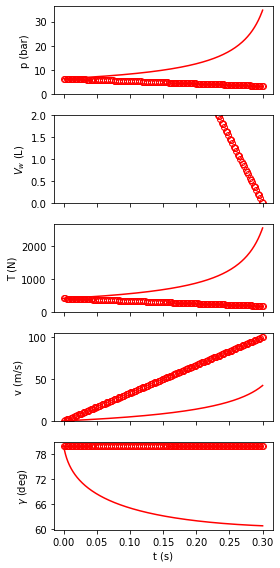

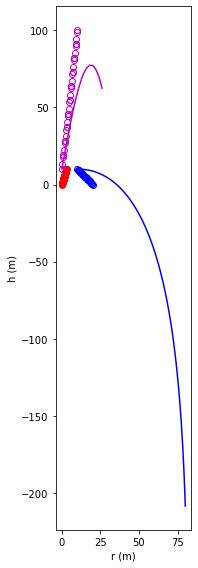

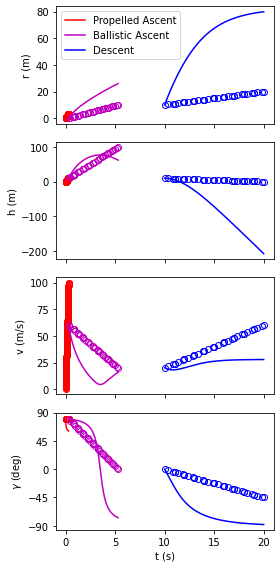

In [36]:
p = om.Problem(model=om.Group())

traj, phases = new_water_rocket_trajectory(objective='range')
traj = p.model.add_subsystem('traj', traj)

p.driver = om.pyOptSparseDriver(optimizer='SNOPT')
p.driver.opt_settings['Verify level'] = 3
p.driver.opt_settings['iSumm'] = 6
# p.driver.opt_settings['print_level'] = 5
# p.driver.opt_settings['max_iter'] = 1000
# p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'
p.driver.declare_coloring(tol=1.0E-12)

# Finish Problem Setup
p.model.linear_solver = om.DirectSolver()

p.setup()
set_sane_initial_guesses(p, phases)

p.run_driver()

summary = summarize_results(p)
for key, entry in summary.items():
    print(f'{key}: {entry.value:6.4f} {entry.unit}')

exp_out = traj.simulate(times_per_seg=200)

# NOTE: only the last figure is shown in the generated docs
plot_propelled_ascent(p, exp_out)
plot_trajectory(p, exp_out)
plot_states(p, exp_out)

plt.show()

# Check results (tolerance is relative unless value is zero)

In [ ]:
from openmdao.utils.assert_utils import assert_near_equal

# Check results (tolerance is relative unless value is zero)
assert_near_equal(summary['Launch angle'].value, 46, 0.02)
assert_near_equal(summary['Flight angle at end of propulsion'].value, 38, 0.02)
assert_near_equal(summary['Empty mass'].value, 0.189, 1e-2)
assert_near_equal(summary['Water volume'].value, 1.026, 1e-2)
assert_near_equal(summary['Maximum range'].value, 85.11, 1e-2)
assert_near_equal(summary['Maximum height'].value, 23.08, 1e-2)
assert_near_equal(summary['Maximum velocity'].value, 41.31, 1e-2)

## References

```{bibliography}
:filter: docname in docnames
```